# LDA with Gibbs Sampling

**Goal:** Translating the math to an efficient piece of code.

**Dataset:** State of the Union, an annual address by the President of the United States before a joint session of congress. This dataset contains the full text of the State of the Union address from 1791 to 2018.

**Dependencies:**

1. `pip install tqdm, sklearn, scipy, numpy, spacy, matplotlib`
2. `python -m spacy download en_core_web_sm`
3. Unzip `Exercise_10_data.zip`, make sure you have the following directory structure: `./data/sotu/`

**Useful external references:**
1. Murphy, "Machine Learning: A Probabilistic Perspective", Ch. 27.3.

In [9]:
import numpy as np
import spacy
import os
import tqdm.auto as tqdm
import pickle
from scipy.special import digamma, logsumexp

import torch
from torch.distributions.dirichlet import Dirichlet

from collections import Counter

DATA_DIR = './data/'
SOTU_DIR = DATA_DIR + 'sotu/'

## Data preprocessing

Here, we are doing standard preprocessing steps for text data, namely 
* stopword and punctuation removal
* word lemmatization/stemming
* tokenization
* converting text into features

While these steps are not our focus in this exercise, it is very rewarding to study them, since they are standard stuffs in real world applications.

We are using the wonderful [spaCy](https://spacy.io/) library to do this. Once the data are preprocessed, we will store them in files for future uses, since these steps only need to be done once. So:

**Skip the following cell if you have already successfully run it, to save time**

In [10]:
# nlp = spacy.load('en_core_web_sm')
# years = []  # Useful for visualization
# preprocessed = []

# for fname in tqdm.tqdm(os.listdir(SOTU_DIR)):
#     if not fname.endswith('.txt'):
#         continue
        
#     years.append(int(fname[-8:-4]))  # Extract the year from the filename
        
#     with open(SOTU_DIR+fname, 'r') as f:
#         doc = nlp(f.read())
#         bow = []
        
#         for token in doc:
#             if token.is_stop or token.is_punct:
#                 continue
                
#             bow.append(token.lemma_)

#         preprocessed.append(' '.join(bow))
        
# with open(DATA_DIR+'years.bin', 'wb') as f:
#     pickle.dump(years, f)
        
# with open(DATA_DIR+'preprocessed.bin', 'wb') as f:
#     pickle.dump(preprocessed, f)
    
# print(f'Saved as: {DATA_DIR+"years.bin"} and {DATA_DIR+"preprocessed.bin"}!')

Now, we load the saved, preprocessed data.

In [11]:
with open(DATA_DIR+'years.bin', 'rb') as f:
    years = pickle.load(f)

with open(DATA_DIR+'preprocessed.bin', 'rb') as f:
    preprocessed = pickle.load(f)

Here, our goal is to build a vocabulary, assign an ID to each word in the vocabulary, and convert the documents (sequence of words) into features (sequence of word ID). Again, this is not our focus, so we will just use scikit-learn for doing this, but it is definitely worth your effort to study this step.

**Hint.** You might want to tune `MAX_DOC_LEN` and `VOCAB_SIZE` to make things faster. For the final submission, please be reasonable with this values---do not set them to values that are too small, e.g. < 100!

In [12]:
from sklearn.feature_extraction.text import CountVectorizer


# Reduce these values to make things faster, e.g. for debugging
# MAX_DOC_LEN = 2000
# VOCAB_SIZE = 1000
MAX_DOC_LEN = 1000
VOCAB_SIZE = 500
# MAX_DOC_LEN = 200
# VOCAB_SIZE = 100

count_vect = CountVectorizer(max_features=VOCAB_SIZE, stop_words=['000'])
count_vect = count_vect.fit(preprocessed)

word2idx = count_vect.vocabulary_
idx2word = count_vect.get_feature_names()

W = []
index = 0
for doc in preprocessed:
    w = []
    
    for word in doc.split(' '):
        if len(w) >= MAX_DOC_LEN:
            break
        
        try:
            idx = word2idx[word]
            w.append(idx)
        except KeyError:
            pass
        
    if len(w) > 0:
        W.append(w)
    else:
#             print(index)
        yrs_correct = np.delete(years, index, 0)
    index += 1
#     W.append(w)

## LDA inference via Gibbs sampling

With preprocessing stuffs done, we are ready to actually implement a Gibbs sampling algorithm for doing LDA inference. But first, here are some hyperparameters. Note that the standard choice of the Dirichlet priors' parameters $\alpha, \beta$ is $1/K$, where $K$ is the number of topics. This is just a heuristic; if you are curious what does this hyperparameters actually means, you can follow this wonderful lecture by David Blei from Machine Learning Summer School 2009 here: http://videolectures.net/mlss09uk_blei_tm/.

In [13]:
V = VOCAB_SIZE  # vocabulary size
D = len(W)  # num of docs
K = 10  # num of topics

# Dirichlet priors
alpha = 1/K
beta = 1/K

**TASK 1.** Here's your first task: Initialize the necessary quantities, namely 

* $\mathbf{\Pi}$, the document-topic proportions
* $\mathbf{\Theta}$ the topic-word proportions
* $\mathbf{C}$ the document-word topic assignments

by sampling from the priors and following the generative process.

**Hint.** You are not required to follow the definitions in the slides. In fact, how you define those variables might affect the algorithm's efficiency!

In [8]:
# remove document with len = 0
# W = [W[i] for i in range(D) if len(W[i]) != 0 ]
# D = len(W)

In [17]:
# Pi := document topic distribution
Pi =  Dirichlet(torch.tensor([alpha]*K)).rsample((D,))

# Theta := topic-word distribution
Theta =  Dirichlet(torch.tensor([beta]*V)).rsample((K,))

C = [torch.multinomial(Pi[i], len(W[i]), replacement=True) for i in range(D)]

**TASK 2.** Now we need to _efficiently_ implement the Gibbs sampler. The code skeleton is provided---you only need to "translate" the mathematical expressions in the full-conditionals of $\mathbf{\Pi}, \mathbf{\Theta}, \mathbf{C}$ into a code. You should use the lecture slides as a reference.

**Hint:**

1. Implement the Gibbs sampler naively first. It will be really slow but it is a useful starting point.
2. Identify a vectorized-able code segment.
3. Vectorize it.
4. Run the cell again, note the runtime.
5. Go to step 2 until satisfied or no more code can be vectorized.


**Note.** Below, `topic_word_props_importance` simply means the usual topic-word proportions that are "weighted" (practically: divided) by their marginal over the topics. The idea is: Words that prominently presents in a topic and  rarely occurs in other topics are important to that topic. The intuition is similar to [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

In [18]:
N_SAMPLES = 20  # Number of samples to be obtained
BURN_IN = 50  # Wait for k iterations before start taking samples
THINNING = 5  # Take sample every k-th iteration

N_ITER = BURN_IN + N_SAMPLES * THINNING


# Sum topic-word-proportion and doc-topic-proportion over samples
# Used to compute the expectation of them, for "predictions" and visualizations
total_topic_word_props = 0
total_topic_word_props_importance = 0
total_doc_topic_props = 0
n_samples = 0

W_np = [np.array(W[i]) for i in range(len(W))]
W_cnt = [Counter(W[i]) for i in range(len(W))]
C_np = [np.array(C[i]) for i in range(len(C))]
# print(C_np[0] == 0)

for it in tqdm.trange(N_ITER):
    doc_topic_mask = [[C_np[d] == k for k in range(K)] for d in range(len(C_np))]
    N = torch.tensor([[[np.sum(v == W_np[d][doc_topic_mask[d][k]]) for v in range(V)] for k in range(K)] for d in range(len(W_np))])
    # Sample from the full conditional of Theta
    # -----------------------------------------
    Theta = Dirichlet(beta+N.sum(axis=0)).sample()
     
    # Sample from the full conditional of Pi
    # --------------------------------------
    Pi = Dirichlet(alpha+N.sum(axis=-1)).sample()
    
    # Sample from the full conditional of C
    # -------------------------------------
    pi_theta_k = torch.einsum('ik,kj->ijk', Pi, Theta)
    pi_theta_k /= torch.sum(pi_theta_kmax, axis=-1, keepdims=True)
    C_np = [np.array([torch.multinomial(pi_theta_k[d,W[d][j]], 1) for j in range(len(W[d]))]) for d in range(D)]

    # Take samples and compute the running sums
    # -----------------------------------------
    if it >= BURN_IN:
        if (it - BURN_IN) % THINNING == 0:
            total_topic_word_props += Theta
            total_topic_word_props_importance += Theta/Theta.sum(0, keepdims=True)
            total_doc_topic_props += Pi
            n_samples += 1            
            
print(f'Obtained {n_samples} samples')
            
            
# Obtain the expected topic-word-proportion and doc-topic-proportion over samples
# -------------------------------------------------------------------------------
topic_word_props = total_topic_word_props / n_samples
topic_word_props_importance = total_topic_word_props_importance / n_samples
doc_topic_props = total_doc_topic_props / n_samples


Obtained 20 samples


## Testing

Let's check your implementation, whether it yields some nice/coherent topics or not. This is a quick indicator whether the inference is successful or not. More quantitative metrics exist, but they are outside of the scope of this exercise.

**TASK 3.** For each topic, print out `n_top` of the most probable important words, as encoded in `topic_word_props_importance`. Example outputs (`n_top = 8`):

```
Topic-1
enemy army war ship fight navy sea supply

Topic-2
currency gold treasury article convention payment minister delay

...
```

In [19]:
n_top = 8

top_vals, inds = torch.topk(topic_word_props_importance, n_top, axis=-1)
np_idx2word = np.array(idx2word)
print(np_idx2word[inds])

[['china' 'agriculture' 'farmer' 'reduction' 'agency' 'credit' 'price'
  'surplus']
 ['secretary' 'republic' 'island' 'conference' 'navy' 'europe' 'naval'
  'international']
 ['corporation' 'industrial' 'labor' 'deal' 'tariff' 'method' 'capital'
  'man']
 ['constitution' 'minister' 'treasury' 'render' 'south' 'honor' 'article'
  'post']
 ['mail' 'currency' 'gold' 'fiscal' 'expenditure' '30' 'note' 'bond']
 ['strength' 'area' 'achieve' 'fight' 'world' 'essential' 'human'
  'defense']
 ['job' 'tonight' 'worker' 'health' 'cut' 'woman' 'family' 'child']
 ['percent' 'billion' 'budget' 'tonight' 'let' 'school' 'cut' 'child']
 ['indian' 'congress' 'article' 'british' 'vessel' 'port' 'river'
  'commissioner']
 ['constitutional' 'political' 'executive' 'department' 'civil' 'army'
  'branch' 'express']]


As you have seen in the lecture, latent semantic analysis/indexing (LSA/LSI)---a topic-modelling algorithm based on matrix-decomposition---yields _non-sparse_ solutions.


**TASK 4.** Show that LDA yields _sparse_ **document-topic** and **topic-word proportions**. Plot some of these proportions, so that we can visually inspect the sparsity of LDA.

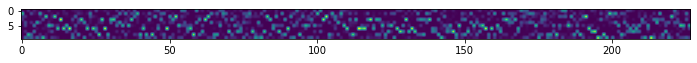

In [20]:
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"]=12,12
plt.imshow(doc_topic_props.T)
#plt.imshow(topic_word_props)
plt.show()

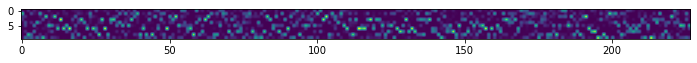

In [21]:
plt.rcParams["figure.figsize"]=12,12
plt.imshow(doc_topic_props.T)
#plt.imshow(topic_word_props)
plt.show()

Finally, it would be interesting to see the change of topics over time.

**TASK 5.** Plot the document-topic proportion sequentially, ordered by year. See Fig. 5 in https://arxiv.org/abs/1110.4713 for an example.

**Hint.** Remember that we have the variable `years` (cf. cell 2 and 3) containing the corresponding year of the documents (the document list might not be ordered!).

In [22]:
yrs = np.array(years)
yrs_sort_index = yrs_correct.argsort()
doc_topic_props[yrs_sort_index][0]
yrs_sorted = yrs_correct[yrs_sort_index]

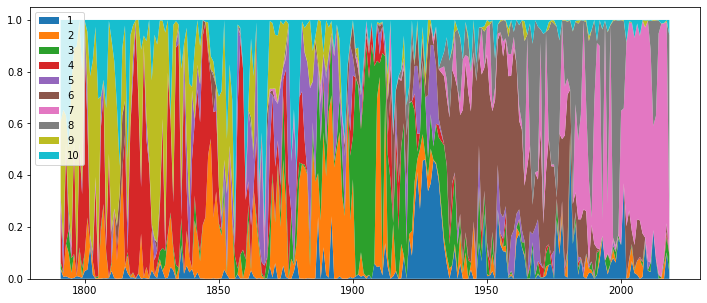

In [24]:
plt.rcParams["figure.figsize"]=12,5
plt.stackplot(yrs_sorted, doc_topic_props[yrs_sort_index].T, labels=["1","2","3","4","5","6","7","8","9","10"])
plt.legend(loc='upper left')
plt.show()